#### Hotel Sentiment - Model Building
In this project, we will build a model which can predict whether a customer is happy or not happy based on the reviews given by them. 
The sentiment analysis part is covered in the another notebook separately, so here we will concentrate only on model building

In [1]:
# importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import gensim
import warnings
warnings.filterwarnings('ignore')

In [2]:
# importing the training dataset
df=pd.read_csv('train.csv')
df=df.sample(frac=1).reset_index(drop=True) # Shuffling the dataset
df.head()

,User_ID,Description,Browser_Used,Device_Used,Is_Response
0,id45259,Just returned from a fabulous --night stay at ...,Safari,Mobile,happy
1,id40195,Stayed at this hotel for a conference and the ...,Mozilla Firefox,Desktop,happy
2,id46251,Stayed here for more than a week in May. When ...,Mozilla Firefox,Tablet,happy
3,id16066,We stayed at the Hudson for - days as last ste...,Mozilla,Desktop,not happy
4,id42487,The bed was lumpy. Room was clean but this Hil...,Firefox,Mobile,not happy


In [3]:
df=df.iloc[:5000,:] # selecting only 5000 rows as large file will not run in the system
df.shape

(5000, 5)

In [5]:
# Dropping columns like user_id, browser used and device used which is of no much importance
df.drop(['User_ID', 'Browser_Used', 'Device_Used'],axis=1,inplace=True) 
df.head()

,Description,Is_Response
0,Just returned from a fabulous --night stay at ...,happy
1,Stayed at this hotel for a conference and the ...,happy
2,Stayed here for more than a week in May. When ...,happy
3,We stayed at the Hudson for - days as last ste...,not happy
4,The bed was lumpy. Room was clean but this Hil...,not happy


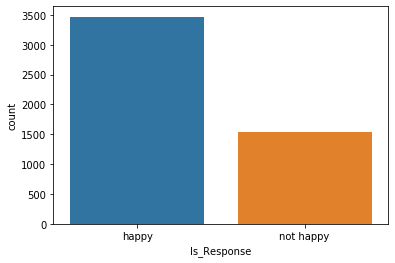

In [6]:
sns.countplot(df['Is_Response'])

In [7]:
# the value counts of happy and not happy
print("The value counts of happy and not happy", '\n',df['Is_Response'].value_counts())

The value counts of happy and not happy 
 happy        3468
not happy    1532
Name: Is_Response, dtype: int64


In [8]:
# Ratio of the value counts 
print("Happy Ratio = ", round(len(df[df['Is_Response']=='happy'])/len(df.Is_Response),2)*100,'%')
print("Not Happy Ratio==",round(len(df[df['Is_Response']=='not happy'])/len(df.Is_Response),2)*100,'%')

Happy Ratio =  69.0 %
Not Happy Ratio== 31.0 %


In [9]:
# importing necessary libraries for pre processing texts
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from string import punctuation
import string
import re
wordnet=WordNetLemmatizer()

In [10]:
# pre processing the text
corpus=[]
for i in range(0,len(df)):
    review=re.sub('[^a-zA-Z]',' ', df['Description'][i])
    review=review.lower()
    review=review.split()
    review=[wordnet.lemmatize(word) for word in review if not word in stopwords.words('english')]
    review=' '.join(review)
    corpus.append(review)

#### Model building


In [11]:
len(corpus)

5000

In [12]:
# labelling the target variable
df['Is_Response']=pd.get_dummies(df['Is_Response'])


In [13]:
df['Is_Response'].value_counts()

1    3468
0    1532
Name: Is_Response, dtype: int64

#### trying logistic regression using count vectorizer
Let us find and compare the model accuracy using count vectorizer and Tfidfvectorizer and we can select better amongst them

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression

vec=TfidfVectorizer()
cv=CountVectorizer()
lg=LogisticRegression()
bayes=GaussianNB()

x=cv.fit_transform(corpus).toarray()



In [23]:
x.shape

(5000, 15932)

In [24]:
y=pd.DataFrame(df['Is_Response'])

In [25]:
# train and test data splitting
train_x,test_x,train_y,test_y=train_test_split(x,y,random_state=42,test_size=0.20)



In [26]:
# testing the data using countvectorizer
lg.fit(train_x,train_y)
pred=lg.predict(test_x)
acc_score=accuracy_score(pred,test_y)
print("Accuracy Score is", acc_score)
print(confusion_matrix(pred,test_y))
print(classification_report(pred,test_y))
print("The cross validation score is", cross_val_score(lg,x,y,cv=5).mean())

Accuracy Score is 0.842
[[211  46]
 [112 631]]
              precision    recall  f1-score   support

           0       0.65      0.82      0.73       257
           1       0.93      0.85      0.89       743

    accuracy                           0.84      1000
   macro avg       0.79      0.84      0.81      1000
weighted avg       0.86      0.84      0.85      1000

The cross validation score is 0.8423962751962751


##### Now let us use Tfidf on the same model

In [28]:
x=vec.fit_transform(corpus).toarray()
train_x,test_x,train_y,test_y=train_test_split(x,y,random_state=42,test_size=0.20)

In [29]:
lg.fit(train_x,train_y)
pred=lg.predict(test_x)
acc_score=accuracy_score(pred,test_y)
print("Accuracy Score is", acc_score)
print(confusion_matrix(pred,test_y))
print(classification_report(pred,test_y))
print("The cross validation score is", cross_val_score(lg,x,y,cv=5).mean())

Accuracy Score is 0.843
[[187  21]
 [136 656]]
              precision    recall  f1-score   support

           0       0.58      0.90      0.70       208
           1       0.97      0.83      0.89       792

    accuracy                           0.84      1000
   macro avg       0.77      0.86      0.80      1000
weighted avg       0.89      0.84      0.85      1000

The cross validation score is 0.8565972837972836


In [30]:
#since tfidf is giving very slightly better scores, we can try different models based on the same

In [31]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

models=[LogisticRegression(),DecisionTreeClassifier(),KNeighborsClassifier(),SVC(),GaussianNB()]

for i in models:
    i.fit(train_x,train_y)
    pred=i.predict(test_x)
    print(i)
    print("\nAccuracy Score",accuracy_score(pred,test_y))
    print(classification_report(pred,test_y))
    print(confusion_matrix)
    print("")
    print("The cross validation score is", cross_val_score(i,x,y,cv=5).mean())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

Accuracy Score 0.843
              precision    recall  f1-score   support

           0       0.58      0.90      0.70       208
           1       0.97      0.83      0.89       792

    accuracy                           0.84      1000
   macro avg       0.77      0.86      0.80      1000
weighted avg       0.89      0.84      0.85      1000

<function confusion_matrix at 0x000001E4E6A0B048>

The cross validation score is 0.8565972837972836
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
            

In [32]:
score=pd.DataFrame({'Model':models,'Accuracy Score':[0.843,0.731,0.772,0.667,0.594], 'Cross Validation Score':[0.856,0.737,0.781,0.693,0.564]})
score
# Logistic Regression is giving better score amongst the models

,Model,Accuracy Score,Cross Validation Score
0,"LogisticRegression(C=1.0, class_weight=None, d...",0.843,0.856
1,"DecisionTreeClassifier(class_weight=None, crit...",0.731,0.737
2,"KNeighborsClassifier(algorithm='auto', leaf_si...",0.772,0.781
3,"SVC(C=1.0, cache_size=200, class_weight=None, ...",0.667,0.693
4,"GaussianNB(priors=None, var_smoothing=1e-09)",0.594,0.564


In [34]:
# Lets try if ensemble methods give better results
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
AS=[]
CV=[]

ensemble=[RandomForestClassifier(),GradientBoostingClassifier(),AdaBoostClassifier(), XGBClassifier()]
for i in ensemble:
    i.fit(train_x,train_y)
    pred=i.predict(test_x)
    print(i)
    score=accuracy_score(test_y,pred)
    print("Accuracy Score is", score)
    AS.append(score)
    cvs=cross_val_score(i,x,y,cv=5).mean()
    print("The cross validation score is", cvs)
    CV.append(cvs)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Accuracy Score is 0.771
The cross validation score is 0.7843952285952286
GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
        

In [37]:
ensemblescore=pd.DataFrame({'Ensemble_Models':['Random Forest Classifier','Gradient Boosting Classifier','AdaBoost Classifier','XGB Classifier'],'Accuracy Score':AS,'Cross Validation Score':CV})
ensemblescore

,Ensemble_Models,Accuracy Score,Cross Validation Score
0,Random Forest Classifier,0.771,0.784395
1,Gradient Boosting Classifier,0.813,0.825797
2,AdaBoost Classifier,0.795,0.809997
3,XGB Classifier,0.821,0.845198


In [38]:
# Since Logistic Regression is performing better when compared to ensemble methods, 
#let us find best parameters using GridSearchcv for logistic regression
from sklearn.model_selection import GridSearchCV
grid={'C':np.logspace(-3,3.7), 'penalty':['l1','l2']}
gridcv=GridSearchCV(lg,grid,cv=10)
gridcv.fit(train_x,train_y)
print(gridcv.best_params_)

{'C': 2.620398528858349, 'penalty': 'l2'}


In [40]:
lg=LogisticRegression(C=2.62,penalty='l2')
lg.fit(train_x,train_y)
pred=lg.predict(test_x)
print("Accuracy Score is", accuracy_score(test_y,pred))
print("The cross validation score is", cross_val_score(lg,x,y,cv=5).mean())
print(classification_report(test_y,pred))
print(confusion_matrix(test_y,pred))

Accuracy Score is 0.855
The cross validation score is 0.8657968917968919
              precision    recall  f1-score   support

           0       0.88      0.64      0.74       323
           1       0.85      0.96      0.90       677

    accuracy                           0.85      1000
   macro avg       0.86      0.80      0.82      1000
weighted avg       0.86      0.85      0.85      1000

[[206 117]
 [ 28 649]]


In [41]:
# The results have slightly increased. Hence, we can finalise the model
from sklearn.externals import joblib
joblib.dump(lg,'Hotel_Sentiment_LG.pkl')

['Hotel_Sentiment_LG.pkl']

In [42]:
# Testing results on the test data
testdf=pd.read_csv("test.csv")
testdf.head()

,User_ID,Description,Browser_Used,Device_Used
0,id80132,Looking for a motel in close proximity to TV t...,Firefox,Mobile
1,id80133,Walking distance to Madison Square Garden and ...,InternetExplorer,Desktop
2,id80134,Visited Seattle on business. Spent - nights in...,IE,Tablet
3,id80135,This hotel location is excellent and the rooms...,Edge,Mobile
4,id80136,This hotel is awesome I love the service Antho...,Mozilla,Mobile


In [43]:
testdf.drop(['User_ID', 'Browser_Used', 'Device_Used'],axis=1,inplace=True) 
testdf=testdf.sample(frac=1).reset_index(drop=True) # Shuffling the dataset
testdf=testdf.iloc[:5000,:] # selecting only 5000 rows as large file will not run in the system
testdf.shape

(5000, 1)

In [54]:
testcorpus=[]
for i in range(0,len(testdf)):
    review=re.sub('[^a-zA-Z]',' ', testdf['Description'][i])
    review=review.lower()
    review=review.split()
    review=[wordnet.lemmatize(word) for word in review if not word in stopwords.words('english')]
    review=' '.join(review)
    testcorpus.append(review)

In [57]:
testcorpus

['although lot noise due wtc construction site amazing stay hilton incredible view',
 'good experience hotel room clean property located right next metro rail perfect walk right catch train bus need car went san diego breakfast buffet adequate pillow bit hard boyfriend friend mind relative yes picture bit weird room hall picture found nice stay would recommend would stay san diego',
 'love older historic property favorite hotel san diego hotel del coronado stayed many time always original victorian building u grant revelation gaslamp horton plaza right doorstep shopping restaurant kind activity within easy walk building noted quirky totally expected give older property charm room odd size hallway lead nowhere finish quality flawless speaking room upgraded large corner room white wall set dark wenge wood floor dramatic original art flat screen tv large desk area enormous bathroom dressing area made room terrific notice noise window also noticed noise creaky floor hallway hotel really co

In [ ]:
##### Using TfIdf to fit_transform separately and to use toarray() separately for training data

In [58]:
x=vec.fit_transform(corpus)
x.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [59]:
# Using only transform to the testcorpus so that it is trained on the basis on already trained training dataset
# This ensures the dimensions of both training and test dataset are the same
testdata=vec.transform(testcorpus).toarray()

In [60]:
testdata.shape

(5000, 15932)

In [62]:
predtest=pd.DataFrame(lg.predict(testdata))
predtest.to_csv('prediction_testdata.csv')